In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.neighbors import KNeighborsClassifier as kNearNeighbor
from sklearn import tree

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as L

from sklearn.decomposition import PCA

In [2]:
from IPython.core.display import display, HTML
# make the screen wide
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# Load the csv files over here into pandas data frame
# YOUR CODE HERE
# 0.1
def load_csv(file_name):
    return pd.read_csv(file_name)

# Part 1 - Data cleaning, normalization and missing value fillup

In [167]:
'''
Designated missing_filler1 method to be Median/Mean Imputation Algorithm (input specifies which one)
'''
def missing_filler1(df_in, method):
    # determine method to be used median or mean imputation
    if method == 'median':
        impute_values = df.median().values
    elif method == 'mean':
        impute_values = df.mean().values
    
    # get the cols of the df
    cols = df_in.columns.values
    
    # iterate the cols
    for i,c in enumerate(cols):
        # get the index of the samples that have nan in them at the current column
        nan_rows = df_in.loc[df_in[c].isna() == True].index.values
        if len(nan_rows) > 0: # if there are samples with nan at the current row
            for row in nan_rows: # iterate the samples that have nan
                df_in.loc[row, c] = impute_values[i] # replace the nan value with the imputed value

In [168]:
'''
Designated missing_filler2 method to be Hot Deck Imputation Algorithm (using either l1 or l2 norm)
'''
# calculate l1 distance between the two data samples
def l1(rx, tx):
    diff = 0
    for r,t in zip(rx, tx):
        if not pd.isna(r):
            diff += abs(r-t)
    return diff

# calculate l2 distance between the two data samples
def l2(rx, tx):
    diff = 0
    for r,t in zip(rx, tx):
        if not pd.isna(r):
            diff += (r-t)**2
    return (diff)**(1/2)

# Hot Deck Imputation
def missing_filler2(df_in, method):
    # get the columns of the df
    cols = df_in.columns.values
    # iterate the rows of the dataframe
    for index_rx, data_rx in df_in.iterrows():
        nans = data_rx.isna().sum() # count nans in row
        if nans > 0:
            # find a donor row
            max_simi  = 9999999
            for index_tx, data_tx in df_in.iterrows(): # nested iteration of the dataframe
                nans = data_tx.isna().sum() # count nans in row
                if nans == 0 and not index_rx == index_tx: # if there are no nans in the donor row and the donor row is not the original row
                    if method == 'l1':
                        diff = l1(data_rx, data_tx) # calculate l1 norm
                    else: 
                        diff = l2(data_rx, data_tx) # calculate l2 norm
                    if diff < max_simi: # if the norm is less than the previous found lowest norm, replace it and track the index
                        max_simi = diff
                        donor_idx = index_tx
            for c in cols: # iterate the columns at the current row
                if pd.isna(df_in.loc[index_rx,c]): # if the current row,col value is nan, replace it with the donor row,col value
                    df_in.loc[index_rx,c] = df_in.loc[donor_idx,c]

In [169]:
'''
Designated missing_filler3 method to drop all rows with a nan value
'''
def missing_filler3(df_in):
    # iterate the rows of the dataframe
    for index, data in df_in.iterrows():
        nans = data.isna().sum() # count nans in row
        if nans > 0:
            df_in.drop(index, inplace=True) # drop the row in place

In [170]:
def cleaning(df_in, threshold):
    # get columns of df
    cols = df_in.columns.values
    thresh = int(df_in.shape[0]*.15)
    # iterate features of df and check nan count, if count for feature > 15% of data remove column
    for c in cols:
        nans = df_in[c].isna().sum() # get nan count
        if nans > thresh: # conditional on nan count > 15% of samples
            df_in.pop(c) # remove column
    
    # get col names again in case one was removed
    cols = df_in.columns.values
    # check for inf value and replace with nan
    for c in cols:
        inf_rows = df_in.loc[np.isinf(df_in[c]) == True].index.values
        if len(inf_rows) > 0:
            for row in inf_rows:
                df_in.loc[row, c] = None

    # iterate the rows of the dataframe
    for index, data in df_in.iterrows():
        nans = data.isna().sum() # count nans in row
        if nans > threshold: # conditional if nan count > 25% of # cols (3), remove sample
            df_in.drop(index, inplace=True) # drop the row in place
    

In [171]:
# helper function to get the mean, max and min for min max normalization using train norms
def stats(df_in):
    return df_in.mean(), df_in.max(), df_in.min() 

def normalizer(df_in, means, maxs, mins):
    return (df_in - means) / (maxs - mins)


# Part 2 - Model training and testing

In [172]:
# Splitting the dataset into train, val and test sets.
# 2.0
def tts(X,y,test_size=0.2, seed=0):
    return train_test_split(X, y, test_size = test_size, random_state=seed)

In [437]:
# Code for different models used.

def LR(c=1):
    model = LogisticRegression(max_iter=300, multi_class='ovr', C=c).fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    return y_train_pred, y_val_pred, model

def RF(depth=7, max_features=5, estimators=500, min_samples_split=3):
    model = RandomForest(max_depth=depth, max_features=max_features, min_samples_split=min_samples_split, n_estimators=estimators, criterion='entropy').fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    return y_train_pred, y_val_pred, model

def kNN(n=3, algo='auto', p=2):
    model = kNearNeighbor(n_neighbors=n, weights='distance', algorithm=algo, p=p).fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    return y_train_pred, y_val_pred, model

def NN(batch_size=10, epochs=5):
    n_cols = X_train.shape[1]
    
    model = Sequential()
    model.add(L.Dense(n_cols, activation='relu', input_shape=(n_cols,)))
    model.add(L.Dense(100, activation='relu'))
    model.add(L.Dense(100, activation='relu'))
    model.add(L.Dense(100, activation='relu'))
    model.add(L.Dense(100, activation='relu'))
    model.add(L.Dense(100, activation='relu'))
    model.add(L.Dense(100, activation='relu'))
    model.add(L.Dropout(0.45))
    model.add(L.Dense(3, activation=tensorflow.nn.softmax)) 

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_val,y_val),batch_size=batch_size, epochs=epochs, verbose=1, callbacks=callbacks)
    
    y_pred_test = model.predict(X_val)
    y_pred = np.argmax(y_pred_test, axis = 1)
    
    return y_pred, model


In [174]:
# Create function which calculates F1score, precision, recall and accuracy score for true and predicted labels.
def metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    prec = precision_score(y_true, y_pred, average='weighted')
    print(f'F1 Score: {f1}')
    print(f'Accuracy Score: {acc}')
    print(f'Precision: {prec}')
    print(f'Recall: {recall}')
    print()

# Part 3 - Interpretability

In [486]:
# Look into using suitable functions from sklearn. Explain your code and findings clearly in the report document.
# 3.1
def FeatureImportance(model,k=5):
    coefs = list(abs(model.coef_[0]))
    cols = list(X_train.columns.values)
    
    # iterate the coefs and sort the columns in descending importance of feature weight
    sorted_cols = []
    for i in range(len(coefs)-1):
        max_ = np.argmax(coefs) #get the highest value weight
        coefs.pop(max_) # pop the coef value
        sorted_cols.append(cols.pop(max_)) # pop the column name and append to the sorted columns list
        
    coefs = list(abs(model.coef_[0]))
    cols = list(X_train.columns.values)
    plt.plot(cols, coefs)
    plt.title('Features vs Absolute Value of Feature Weight', color='white')
    plt.xticks(rotation=90)
    plt.show()
    
    return sorted_cols[:k] # return the top k features
  

In [487]:
def FeatureImportanceForPairs(top_k, X, y):
    f1s = []
    pairs = []
    for i in range(len(top_k)-1):
        for j in range(i+1,len(top_k)):
            
            temp_df = pd.DataFrame()
            temp_df[top_k[i]] = X[top_k[i]]
            temp_df[top_k[j]] = X[top_k[j]]
            
            X_train, X_val, y_train, y_val = tts(temp_df, y, test_size=0.2, seed=0)
            
            model = LogisticRegression(max_iter=300, multi_class='ovr', C=62).fit(X_train, y_train)
            y_val_pred = model.predict(X_val)
            
            f1s.append(f1_score(y_val, y_val_pred, average='weighted'))
            pairs.append(f'{top_k[i]}, {top_k[j]}')
            
    plt.plot(pairs, f1s)
    plt.title('F1 Score vs Top Feature Pairs', color='white')
    plt.xticks(rotation=90)
    plt.show()
    
    sorted_pairs = []
    for i in range(len(f1s)-1):
        max_ = np.argmax(f1s) #get the highest value weight
        f1s.pop(max_) # pop the f1 value
        sorted_pairs.append(pairs.pop(max_)) # pop the column name and append to the sorted columns list
    
    return f1s, sorted_pairs[:len(top_k)]

# Combine all functions together

In [417]:
# load the raw data
df = load_csv('./data/data_2-1.csv')
# remove id column for train/val purposes
_ = df.pop('Id')
_ = df.pop('LF')
_ = df.pop('HF')

''''Clean The Data'''
rows_before, cols_before = df.shape
cleaning(df, int(df.shape[1] * .25))
print(f'{rows_before - df.shape[0]} row(s) removed and {cols_before - df.shape[1]} column(s) removed during data cleaning!\n')

'''Data Imputation Methods'''
y = df.pop('stress') # remove target before imputation
imputation_method = 1 # 1 is mean/median imputation, otherwise is Hot Deck Imputation
method = 'median' # possible values are 'mean' and 'median'
distance = 'l2' # possible vales are 'l1' and 'l2'

if imputation_method == 1:
    print('Beginning Mean Imputation', end='...') if method == 'mean' else print('Beginning Median Imputation', end='...')
    missing_filler1(df, method) # Median/Mean Imputation
elif imputation_method == 2:
    print('Beginning Hot Deck Imputation - l1 distance', end='...') if distance == 'l1' else print('Beginning Hot Deck Imputation - l2 distance', end='...')
    missing_filler2(df, distance) # Hot Deck Imputation using l1 or l2 norm
else:
    print('No Imputation -- remove all rows with nan value')
    df['stress'] = y
    missing_filler3(df)
    y = df.pop('stress')

if df.isna().sum().any() ==  False:
    print('All NaN values imputed from data')

'''Normalization of The Data'''
print('\nNormalizing Data', end='...')
means, maxs, mins = stats(df)
X = normalizer(df, means, maxs, mins)
print('completed')

'''PCA Dimensionality Redction'''
'''pca = PCA(n_components=4)
pca.fit(X)
X_pca = pca.transform(X)
X_pca = pd.DataFrame(X_pca, columns=['pc1', 'pc2', 'pc3', 'pc4'])'''
# attempted some dimensionality reduction but it didnt help much

'''Train Test Split'''
X_train, X_val, y_train, y_val = tts(X, y, test_size=0.2, seed=0)

18 row(s) removed and 1 column(s) removed during data cleaning!

Beginning Median Imputation...All NaN values imputed from data

Normalizing Data...completed


In [442]:
'''Training and Predictions'''
y_train_pred_LR, y_val_pred_LR, model_LR = LR(c=62)
y_train_pred_RF, y_val_pred_RF, model_RF = RF(depth=10, max_features=8, estimators=1500, min_samples_split=4)
y_train_pred_knn, y_val_pred_knn, model_knn = kNN(n=64, algo='auto', p=1.0)

print('Train Metrics -- LR')
metrics(y_train, y_train_pred_LR)
print('Validation Metrics -- LR')
metrics(y_val, y_val_pred_LR)

print('Train Metrics -- RF')
metrics(y_train, y_train_pred_RF)
print('Validation Metrics -- RF')
metrics(y_val, y_val_pred_RF)

print('Train Metrics -- kNN')
metrics(y_train, y_train_pred_knn)
print('Validation Metrics -- kNN')
metrics(y_val, y_val_pred_knn)

Train Metrics -- LR
F1 Score: 0.4708853728800828
Accuracy Score: 0.5466237942122186
Precision: 0.583850849425909
Recall: 0.5466237942122186

Validation Metrics -- LR
F1 Score: 0.4952740795151158
Accuracy Score: 0.5634028892455859
Precision: 0.5539517859018017
Recall: 0.5634028892455859

Train Metrics -- RF
F1 Score: 0.7883619386597412
Accuracy Score: 0.7942122186495176
Precision: 0.8194610942545335
Recall: 0.7942122186495176

Validation Metrics -- RF
F1 Score: 0.6093829923778816
Accuracy Score: 0.6243980738362761
Precision: 0.6181312515960619
Recall: 0.6243980738362761

Train Metrics -- kNN
F1 Score: 0.9995979960198015
Accuracy Score: 0.9995980707395499
Precision: 0.9995984102068306
Recall: 0.9995980707395499

Validation Metrics -- kNN
F1 Score: 0.6154755291697366
Accuracy Score: 0.6276083467094703
Precision: 0.6210599081298945
Recall: 0.6276083467094703



In [438]:
from keras.callbacks import ModelCheckpoint

model_name_acc = './models/best_model_acc12.h5'
model_name_loss = './models/best_model_loss12.h5'

chkpoint1 = ModelCheckpoint(filepath=model_name_acc, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

chkpoint2 = ModelCheckpoint(filepath=model_name_loss, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

callbacks = [chkpoint1, chkpoint2]

In [439]:
y_pred_NN, model_NN = NN(batch_size=311, epochs=150)

print('Validation Metrics -- NN')
metrics(y_val, y_pred_NN)

Epoch 1/150
5/8 [=================>............] - ETA: 0s - loss: 1.0936 - accuracy: 0.4277
Epoch 00001: val_accuracy improved from -inf to 0.51204, saving model to ./models\best_model_acc12.h5

Epoch 00001: val_loss improved from inf to 1.06279, saving model to ./models\best_model_loss12.h5
8/8 [==============================] - 1s 60ms/step - loss: 1.0895 - accuracy: 0.4349 - val_loss: 1.0628 - val_accuracy: 0.5120
Epoch 2/150
5/8 [=================>............] - ETA: 0s - loss: 1.0606 - accuracy: 0.4817
Epoch 00002: val_accuracy did not improve from 0.51204

Epoch 00002: val_loss improved from 1.06279 to 1.02449, saving model to ./models\best_model_loss12.h5
8/8 [==============================] - 0s 32ms/step - loss: 1.0614 - accuracy: 0.4755 - val_loss: 1.0245 - val_accuracy: 0.5120
Epoch 3/150
5/8 [=================>............] - ETA: 0s - loss: 1.0497 - accuracy: 0.4797
Epoch 00003: val_accuracy did not improve from 0.51204

Epoch 00003: val_loss improved from 1.02449 to 1.0

Epoch 22/150
5/8 [=================>............] - ETA: 0s - loss: 0.8729 - accuracy: 0.5762
Epoch 00022: val_accuracy did not improve from 0.62921

Epoch 00022: val_loss improved from 0.81588 to 0.81449, saving model to ./models\best_model_loss12.h5
8/8 [==============================] - 0s 31ms/step - loss: 0.8727 - accuracy: 0.5816 - val_loss: 0.8145 - val_accuracy: 0.6212
Epoch 23/150
5/8 [=================>............] - ETA: 0s - loss: 0.8793 - accuracy: 0.5640
Epoch 00023: val_accuracy did not improve from 0.62921

Epoch 00023: val_loss did not improve from 0.81449
8/8 [==============================] - 0s 21ms/step - loss: 0.8688 - accuracy: 0.5732 - val_loss: 0.8163 - val_accuracy: 0.6212
Epoch 24/150
5/8 [=================>............] - ETA: 0s - loss: 0.8572 - accuracy: 0.5981
Epoch 00024: val_accuracy did not improve from 0.62921

Epoch 00024: val_loss did not improve from 0.81449
8/8 [==============================] - 0s 21ms/step - loss: 0.8754 - accuracy: 0.5792 - va

Epoch 46/150
5/8 [=================>............] - ETA: 0s - loss: 0.8529 - accuracy: 0.5859
Epoch 00046: val_accuracy did not improve from 0.63082

Epoch 00046: val_loss did not improve from 0.80008
8/8 [==============================] - 0s 21ms/step - loss: 0.8408 - accuracy: 0.5888 - val_loss: 0.8007 - val_accuracy: 0.6260
Epoch 47/150
5/8 [=================>............] - ETA: 0s - loss: 0.8365 - accuracy: 0.5768
Epoch 00047: val_accuracy did not improve from 0.63082

Epoch 00047: val_loss did not improve from 0.80008
8/8 [==============================] - 0s 21ms/step - loss: 0.8359 - accuracy: 0.5840 - val_loss: 0.8052 - val_accuracy: 0.6100
Epoch 48/150
5/8 [=================>............] - ETA: 0s - loss: 0.8171 - accuracy: 0.6084
Epoch 00048: val_accuracy did not improve from 0.63082

Epoch 00048: val_loss did not improve from 0.80008
8/8 [==============================] - 0s 21ms/step - loss: 0.8362 - accuracy: 0.5868 - val_loss: 0.8085 - val_accuracy: 0.6083
Epoch 49/150


5/8 [=================>............] - ETA: 0s - loss: 0.7883 - accuracy: 0.6141
Epoch 00070: val_accuracy did not improve from 0.63403

Epoch 00070: val_loss did not improve from 0.78976
8/8 [==============================] - 0s 21ms/step - loss: 0.8091 - accuracy: 0.6089 - val_loss: 0.7965 - val_accuracy: 0.6196
Epoch 71/150
5/8 [=================>............] - ETA: 0s - loss: 0.8026 - accuracy: 0.6032
Epoch 00071: val_accuracy did not improve from 0.63403

Epoch 00071: val_loss did not improve from 0.78976
8/8 [==============================] - 0s 19ms/step - loss: 0.8039 - accuracy: 0.5989 - val_loss: 0.8065 - val_accuracy: 0.5987
Epoch 72/150
5/8 [=================>............] - ETA: 0s - loss: 0.7984 - accuracy: 0.6084
Epoch 00072: val_accuracy did not improve from 0.63403

Epoch 00072: val_loss did not improve from 0.78976
8/8 [==============================] - 0s 19ms/step - loss: 0.8018 - accuracy: 0.6049 - val_loss: 0.8024 - val_accuracy: 0.6196
Epoch 73/150
5/8 [========

Epoch 95/150
5/8 [=================>............] - ETA: 0s - loss: 0.7842 - accuracy: 0.6302
Epoch 00095: val_accuracy did not improve from 0.63403

Epoch 00095: val_loss did not improve from 0.78976
8/8 [==============================] - 0s 20ms/step - loss: 0.7850 - accuracy: 0.6222 - val_loss: 0.7958 - val_accuracy: 0.6244
Epoch 96/150
6/8 [=====================>........] - ETA: 0s - loss: 0.7774 - accuracy: 0.6152
Epoch 00096: val_accuracy did not improve from 0.63403

Epoch 00096: val_loss did not improve from 0.78976
8/8 [==============================] - 0s 19ms/step - loss: 0.7799 - accuracy: 0.6198 - val_loss: 0.8137 - val_accuracy: 0.5795
Epoch 97/150
5/8 [=================>............] - ETA: 0s - loss: 0.7694 - accuracy: 0.6219
Epoch 00097: val_accuracy did not improve from 0.63403

Epoch 00097: val_loss did not improve from 0.78976
8/8 [==============================] - 0s 20ms/step - loss: 0.7771 - accuracy: 0.6258 - val_loss: 0.8116 - val_accuracy: 0.5827
Epoch 98/150


Epoch 120/150
5/8 [=================>............] - ETA: 0s - loss: 0.7720 - accuracy: 0.6277
Epoch 00120: val_accuracy did not improve from 0.63884

Epoch 00120: val_loss did not improve from 0.78976
8/8 [==============================] - 0s 20ms/step - loss: 0.7696 - accuracy: 0.6346 - val_loss: 0.8434 - val_accuracy: 0.6276
Epoch 121/150
8/8 [==============================] - ETA: 0s - loss: 0.7702 - accuracy: 0.6310
Epoch 00121: val_accuracy did not improve from 0.63884

Epoch 00121: val_loss did not improve from 0.78976
8/8 [==============================] - 0s 21ms/step - loss: 0.7702 - accuracy: 0.6310 - val_loss: 0.8251 - val_accuracy: 0.6196
Epoch 122/150
5/8 [=================>............] - ETA: 0s - loss: 0.7722 - accuracy: 0.6322
Epoch 00122: val_accuracy did not improve from 0.63884

Epoch 00122: val_loss did not improve from 0.78976
8/8 [==============================] - 0s 22ms/step - loss: 0.7582 - accuracy: 0.6375 - val_loss: 0.8216 - val_accuracy: 0.6180
Epoch 123/

Epoch 145/150
5/8 [=================>............] - ETA: 0s - loss: 0.7197 - accuracy: 0.6521
Epoch 00145: val_accuracy did not improve from 0.64687

Epoch 00145: val_loss did not improve from 0.78976
8/8 [==============================] - 0s 21ms/step - loss: 0.7240 - accuracy: 0.6491 - val_loss: 0.8410 - val_accuracy: 0.6132
Epoch 146/150
5/8 [=================>............] - ETA: 0s - loss: 0.7221 - accuracy: 0.6444
Epoch 00146: val_accuracy did not improve from 0.64687

Epoch 00146: val_loss did not improve from 0.78976
8/8 [==============================] - 0s 20ms/step - loss: 0.7238 - accuracy: 0.6503 - val_loss: 0.8481 - val_accuracy: 0.6132
Epoch 147/150
5/8 [=================>............] - ETA: 0s - loss: 0.7272 - accuracy: 0.6373
Epoch 00147: val_accuracy did not improve from 0.64687

Epoch 00147: val_loss did not improve from 0.78976
8/8 [==============================] - 0s 21ms/step - loss: 0.7205 - accuracy: 0.6475 - val_loss: 0.8343 - val_accuracy: 0.6356
Epoch 148/

In [440]:
best_model = './models/best_model_loss12.h5'
model_NN.load_weights(best_model)
y_pred = model_NN.predict(X_val)
y_pred = np.argmax(y_pred, axis = 1)
metrics(y_val, y_pred)

F1 Score: 0.6031223106243497
Accuracy Score: 0.6260032102728732
Precision: 0.6216093144294005
Recall: 0.6260032102728732



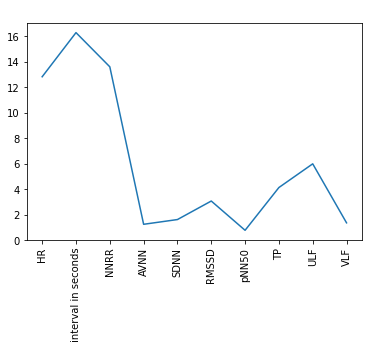

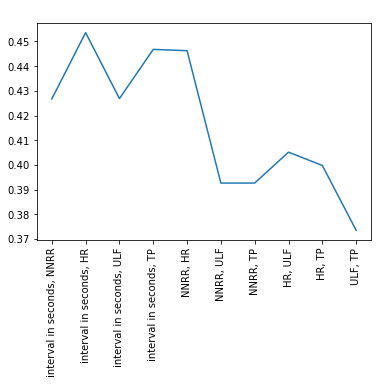

The top 5 features are ['interval in seconds', 'NNRR', 'HR', 'ULF', 'TP']
The top 5 feature paris are: ['interval in seconds, HR', 'interval in seconds, TP', 'NNRR, HR', 'interval in seconds, ULF', 'interval in seconds, NNRR']


In [488]:
top_k = FeatureImportance(model_LR, k =5)
f1s, top_pairs = FeatureImportanceForPairs(top_k, X, y)

print(f'The top 5 features are {top_k}')
print(f'The top 5 feature paris are: {top_pairs}')

# Hyper-parameter Searching

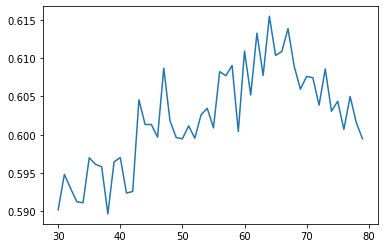

p: 1.0 n: 64
f1:0.6154755291697366


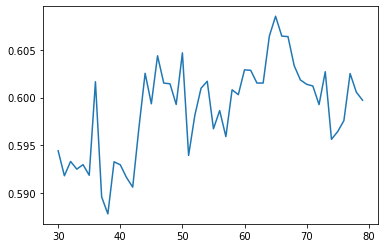

p: 1.1 n: 65
f1:0.6085021463003936


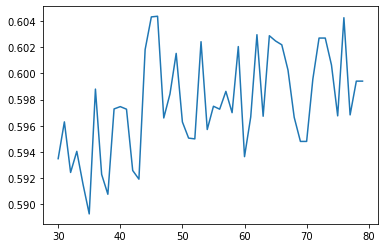

p: 1.2000000000000002 n: 46
f1:0.604368640461444


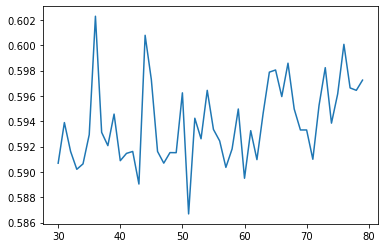

p: 1.3000000000000003 n: 36
f1:0.6022878966226717


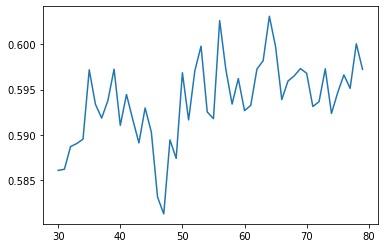

p: 1.4000000000000004 n: 64
f1:0.6031170787731063


KeyboardInterrupt: 

In [430]:
p_values = np.arange(1,3,.1)
n_values = np.arange(30,80,1)

# var to hold f1 scores
f1s = []
max_ = .1
max_p_n = [1,1]

# iterate the possible p values and test range of n values to get best f1 score
for p_ in p_values:
    f1s = []
    for n_ in n_values:
        _, y_val_pred, _ = kNN(n=n_, algo='auto', p=p_) # use knn algorithm
        f1s.append(f1_score(y_val, y_val_pred, average='weighted'))
    # plot the curve for visual explanation
    plt.plot(n_values, f1s)
    plt.show()
    # get max f1 index and print corresponding p and f1 value
    max_f1 = np.argmax(f1s)
    print(f'p: {p_} n: {n_values[max_f1]}\nf1:{f1s[max_f1]}')
    if f1s[max_f1] > max_:
        max_ = f1s[max_f1]
        max_p_n[0] = p_
        max_p_n[1] = n_values[max_f1]
            
print(f'max f1: {max_} @ p={max_p_n[0]} and n={max_p_n[1]}')

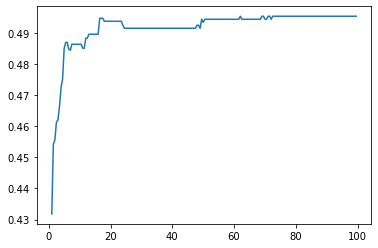

c: 62.0 
f1: 0.4952740795151158


In [441]:
c_values = np.arange(1,100,.5)
# var to hold f1 scores
f1s = []

# iterate the possible c values and test with LR model by running through f1 metric
for c in c_values:
    _, y_val_pred, _ = LR(c)
    f1s.append(f1_score(y_val, y_val_pred, average='weighted'))

# plot the curve for visual explanation
plt.plot(c_values, f1s)
plt.show()

# get max f1 index and print corresponding c and f1 value
max_f1 = np.argmax(f1s)
print('c:', c_values[max_f1], '\nf1:', f1s[max_f1])

# Kaggle Data

In [383]:
X_test = load_csv('./data/kaggle_2.csv')
id_ = X_test.pop('Id')
_ = X_test.pop('LF')
_ = X_test.pop('HF')

# clean test data -- threshold the remove rows at the number of features to ensure no rows are deleted -- basically just an inf checker and remove LF_HF column
cleaning(X_test, df.shape[1])
# use Hot Deck Imputation since data imputation is required
missing_filler1(X_test, 'median')
# normalize using the training stats for same normalization results
X_test = normalizer(X_test, means, maxs, mins)

'''X_pca_test = pca.transform(X_test)
X_pca_test = pd.DataFrame(X_pca_test, columns=['pc1', 'pc2', 'pc3', 'pc4'])

y_pred_test = model_knn.predict(X_pca_test)
'''

y_pred_test = model_RF.predict(X_test)

#y_pred = model_NN.predict(X_test)
#y_pred_test = np.argmax(y_pred, axis = 1)

# prepare data for export 
out_data = {
    'Id' : (id_),
    'stress' : (y_pred_test)
}
# convert data dictionary to dataframe
out_df = pd.DataFrame(out_data)
out_df['stress'] = out_df['stress'].astype(float)
# export
out_df.to_csv('./preds_test.csv', index=False)
print('done')

done
